## 17.3 합성곱 GAN과 바서슈타인 GAN으로 합성 이미지 품질 높이기

### 17.3.1 전치 합성곱

### 17.3.2 배치 정규화

`tf.keras.layers.BatchNormalization()`  

### 17.3.3 생성자와 판별자 구현

`tf.keras.layers.Conv2DTranspose()`

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

In [2]:
if tf.config.list_physical_devices('GPU'):
    device_name = tf.test.gpu_device_name()
else:
    device_name = '/CPU:0'
print(device_name)

/device:GPU:0


In [3]:
# 생성자와 판별자 신경망을 만드는 헬퍼 함수 작성
def make_dcgan_generator(
    z_size=20,
    output_size=(28, 28, 1),
    n_filters=128,
    n_blocks=2):
    size_factor = 2**n_blocks
    hidden_size = (
        output_size[0]//size_factor,
        output_size[1]//size_factor)
    
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(z_size,)),
        
        tf.keras.layers.Dense(
            units=n_filters * np.prod(hidden_size),
            use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Reshape(
            (hidden_size[0], hidden_size[1], n_filters)),
        
        tf.keras.layers.Conv2DTranspose(
            filters=n_filters, kernel_size=(5, 5),
            strides=(1, 1), padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU()
    ])
    
    nf = n_filters
    for i in range(n_blocks):
        nf = nf//2
        model.add(
            tf.keras.layers.Conv2DTranspose(
                filters=nf, kernel_size=(5, 5),
                strides=(2, 2), padding='same',
                use_bias=False))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.LeakyReLU())
        
    model.add(
        tf.keras.layers.Conv2DTranspose(
            filters=output_size[2], kernel_size=(5, 5),
            strides=(1, 1), padding='same', use_bias=False,
            activation='tanh'))
    
    return model

def make_dcgan_discriminator(
    input_size=(28, 28, 1),
    n_filters=64,
    n_blocks=2):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_size),
        tf.keras.layers.Conv2D(
            filters=n_filters, kernel_size=5,
            strides=(1, 1), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU()
    ])
    
    nf = n_filters
    for i in range(n_blocks):
        nf = nf*2
        model.add(
            tf.keras.layers.Conv2D(
                filters=nf, kernel_size=(5, 5),
                strides=(2, 2), padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.LeakyReLU())
        model.add(tf.keras.layers.Dropout(0.3))
        
    model.add(
        tf.keras.layers.Conv2D(
            filters=1, kernel_size=(7, 7),
            padding='valid'))
    
    model.add(tf.keras.layers.Reshape((1,)))
    
    return model

In [4]:
mnist_bldr = tfds.builder('mnist')
mnist_bldr.download_and_prepare()
mnist = mnist_bldr.as_dataset(shuffle_files=False)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [5]:
# preprocess: 펼친 벡터가 아니라 이미지 텐서를 출력하는 것으로 수정
z_size = 20
def preprocess(ex, mode='uniform'):
    image = ex['image']
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    image = image*2 - 1.0
    if mode == 'uniform':
        input_z = tf.random.uniform(
            shape=(z_size,), minval=-1.0, maxval=1.0)
    elif mode == 'normal':
        input_z = tf.random.normal(shape=(z_size,))
    return input_z, image

In [6]:
# 생성자 신경망 만들기
gen_model = make_dcgan_generator()
gen_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              125440    
                                                                 
 batch_normalization (BatchN  (None, 6272)             25088     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        409600    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

In [7]:
# 판별자 신경망 만들기
disc_model = make_dcgan_discriminator()
disc_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        1664      
                                                                 
 batch_normalization_4 (Batc  (None, 28, 28, 64)       256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 28, 28, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 128)       204928    
                                                                 
 batch_normalization_5 (Batc  (None, 14, 14, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 14, 14, 128)      

### 17.3.7 WGAN-GP로 DCGAN 모델 훈련

In [8]:
num_epochs = 100
batch_size = 128
image_size = (28, 28)
z_size = 20
mode_z = 'uniform'
lambda_gp = 10.0
tf.random.set_seed(1)
np.random.seed(1)

# 데이터셋 준비
mnist_trainset = mnist['train']
mnist_trainset = mnist_trainset.map(preprocess)
mnist_trainset = mnist_trainset.shuffle(10000)
mnist_trainset = mnist_trainset.batch(batch_size, drop_remainder=True)

# 모델 생성
with tf.device(device_name):
    gen_model = make_dcgan_generator()
    gen_model.build(input_shape=(None, z_size))
    
    disc_model = make_dcgan_discriminator()
    disc_model.build(input_shape=(None, np.prod(image_size)))

In [9]:
import time
# 옵티마이저
g_optimizer = tf.keras.optimizers.Adam(0.0002)
d_optimizer = tf.keras.optimizers.Adam(0.0002)
if mode_z == 'uniform':
    fixed_z = tf.random.uniform(
        shape=(batch_size, z_size), minval=-1, maxval=1)
elif mode_z == 'normal':
    fixed_z = tf.random.normal(shape=(batch_size, z_size))
    
def create_samples(g_model, input_z):
    g_output = g_model(input_z, training=False)
    images = tf.reshape(g_output, (batch_size, *image_size))
    return (images+1)/2.0

all_losses = []
epoch_samples = []
start_time = time.time()
for epoch in range(1, num_epochs+1):
    
    epoch_losses = []
    
    for i, (input_z, input_real) in enumerate(mnist_trainset):
        
        with tf.GradientTape() as d_tape, tf.GradientTape() as g_tape:
            g_output = gen_model(input_z, training=True)
            d_critics_real = disc_model(input_real, training=True)
            d_critics_fake = disc_model(g_output, training=True)
            
            # 생성자 손실 계싼
            g_loss = -tf.math.reduce_mean(d_critics_fake)
            
            # 판별자 손실을 계산
            d_loss_real = -tf.math.reduce_mean(d_critics_real)
            d_loss_fake = tf.math.reduce_mean(d_critics_fake)
            d_loss = d_loss_real + d_loss_fake
            
            # 그래이디언트 패널티:
            with tf.GradientTape() as gp_tape:
                alpha = tf.random.uniform(
                    shape=[d_critics_real.shape[0], 1, 1, 1],
                    minval=0.0, maxval=1.0)
                interpolated = (alpha * input_real + (1-alpha) * g_output)
                gp_tape.watch(interpolated)
                d_critics_intp = disc_model(interpolated)
                
            grads_intp = gp_tape.gradient(
                d_critics_intp, [interpolated, ])[0]
            grads_intp_l2 = tf.sqrt(
                tf.reduce_sum(tf.square(grads_intp), axis=[1, 2, 3]))
            grad_penalty = tf.reduce_mean(tf.square(
                grads_intp_l2 - 1.0))
            
            d_loss = d_loss + lambda_gp*grad_penalty
        
        # 최적화: 그레이디언트를 계산하고 적용
        d_grads = d_tape.gradient(d_loss,
                                  disc_model.trainable_variables)
        d_optimizer.apply_gradients(
            grads_and_vars=zip(d_grads, disc_model.trainable_variables))
        g_grads = g_tape.gradient(g_loss,
                                  gen_model.trainable_variables)
        g_optimizer.apply_gradients(
            grads_and_vars=zip(g_grads, gen_model.trainable_variables))
        
    epoch_losses.append(
        (g_loss.numpy(), d_loss.numpy(),
         d_loss_real.numpy(), d_loss_fake.numpy()))
    
    all_losses.append(epoch_losses)
    print(
        '에포크 {:03d} | 시간 {:.2f} min | 평균 손실 >> '
        ' 생성자/판별자 {:6.2f}/{:6.2f} [판별자-진짜: {:6.2f}'
        ' 판별자-가짜: {:6.2f}]'
        .format(
            epoch, (time.time() - start_time)/60,
            *list(np.mean(all_losses[-1], axis=0))))
    epoch_samples.append(
        create_samples(gen_model, fixed_z).numpy())

에포크 001 | 시간 1.82 min | 평균 손실 >>  생성자/판별자 191.24/-26.02 [판별자-진짜: -261.82 판별자-가짜: -191.24]
에포크 002 | 시간 3.48 min | 평균 손실 >>  생성자/판별자 138.42/-130.93 [판별자-진짜: -199.16 판별자-가짜: -138.42]
에포크 003 | 시간 5.12 min | 평균 손실 >>  생성자/판별자 199.15/112.80 [판별자-진짜:  63.70 판별자-가짜: -199.15]
에포크 004 | 시간 6.76 min | 평균 손실 >>  생성자/판별자 106.10/ 72.18 [판별자-진짜: 115.86 판별자-가짜: -106.10]
에포크 005 | 시간 8.40 min | 평균 손실 >>  생성자/판별자 159.48/-77.30 [판별자-진짜:  59.40 판별자-가짜: -159.48]
에포크 006 | 시간 10.03 min | 평균 손실 >>  생성자/판별자 202.95/-26.99 [판별자-진짜: 169.23 판별자-가짜: -202.95]
에포크 007 | 시간 11.67 min | 평균 손실 >>  생성자/판별자  25.33/-14.79 [판별자-진짜:  -2.00 판별자-가짜: -25.33]
에포크 008 | 시간 13.30 min | 평균 손실 >>  생성자/판별자  59.95/-119.19 [판별자-진짜: -65.65 판별자-가짜: -59.95]
에포크 009 | 시간 14.94 min | 평균 손실 >>  생성자/판별자 146.52/-20.45 [판별자-진짜: 123.05 판별자-가짜: -146.52]
에포크 010 | 시간 16.57 min | 평균 손실 >>  생성자/판별자  59.09/ 44.72 [판별자-진짜:  70.44 판별자-가짜: -59.09]
에포크 011 | 시간 18.20 min | 평균 손실 >>  생성자/판별자  95.33/-100.97 [판별자-진짜:  -9.52 판별자-가짜: -95.33]
에포크 012 | 시간 1

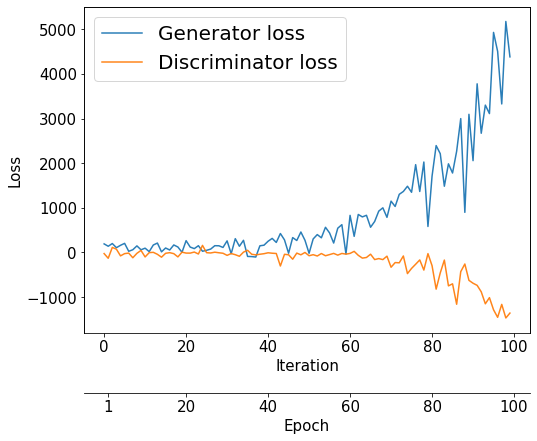

In [11]:
import matplotlib.pyplot as plt
import itertools

fig = plt.figure(figsize=(8, 6))

## 손실 그래프
ax = fig.add_subplot(1, 1, 1)
g_losses = [item[0] for item in itertools.chain(*all_losses)]
d_losses = [item[1] for item in itertools.chain(*all_losses)]
plt.plot(g_losses, label='Generator loss', alpha=0.95)
plt.plot(d_losses, label='Discriminator loss', alpha=0.95)
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Loss', size=15)

epochs = np.arange(1, 101)
epoch2iter = lambda e: e*len(all_losses[-1])
epoch_ticks = [1, 20, 40, 60, 80, 100]
newpos   = [epoch2iter(e) for e in epoch_ticks]
ax2 = ax.twiny()
ax2.set_xticks(newpos)
ax2.set_xticklabels(epoch_ticks)
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 60))
ax2.set_xlabel('Epoch', size=15)
ax2.set_xlim(ax.get_xlim())
ax.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)

plt.show()

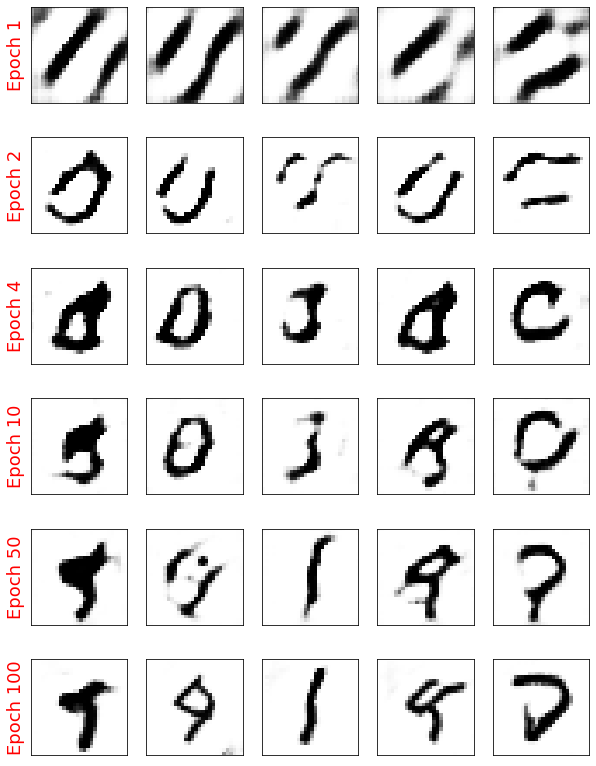

In [12]:
# 몇 가지 샘플로 품질이 어떻게 바뀌는지 확인
import matplotlib.pyplot as plt

selected_epochs = [1, 2, 4, 10, 50, 100]
fig = plt.figure(figsize=(10, 14))
for i, e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i*5+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(-0.06, 0.5, 'Epoch {}'.format(e),
                    rotation=90, size=18, color='red',
                    horizontalalignment='right',
                    verticalalignment='center',
                    transform=ax.transAxes)
            
        image = epoch_samples[e-1][j]
        ax.imshow(image, cmap='gray_r')
plt.show()